# Random Board & Evaluation Generator

Approach 2 to the data generation.

We will create random chess positions and evaluate them ourselves using a common engine, stockfish.

In [1]:
import chess
import chess.engine
import random
import numpy as np

In [2]:
# this function will create the boards we will later evaluate

def random_board_generator(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

In [3]:
# this function will create our evaluation (score)

def stockfish(board, engine, depth):
  result = engine.analyse(board, chess.engine.Limit(depth=depth))
  score = result['score'].white().score()
  return score

In [4]:
# this function will transform any given square into an integer 
# square h3 = 17

def square_to_index(square):
  squares_index = {'a': 0,
                   'b': 1,
                   'c': 2,
                   'd': 3,
                   'e': 4,
                   'f': 5,
                   'g': 6,
                   'h': 7}
                   
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


# this function will store the boards into a matrix so the neural network can work with them
# this will give the tensor input

def split_dims(board):
  # this function will store all board information in matrix format
  # matrix 0-5 represent the positions of white pawns, knights, bishops, rooks, queen and king
  # matrix 6-11 represent the positions of black pawns, knights, bishops, rooks, queen and king
  # matrix 12 represent possible moves for white in this position
  # matrix 13 represent possible moves for black in this position

  # this is the 3d matrix
  board3d = np.zeros((14, 8, 8), dtype=np.int8)

  # here we add the pieces on the matrix
  # one view for each color/type of piece
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add valid moves
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

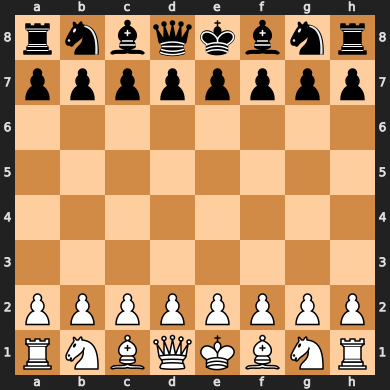

In [7]:
test_board = chess.Board()
test_board

In [9]:
board3d = split_dims(test_board)

In [15]:
# this represents the position of white pawns

board3d[0]

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [14]:
# this represents the position of black bishops

board3d[8]

array([[0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [12]:
# this represents the possible moves for black

board3d[13]

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [9]:
# this function will generate a file that we will use as training set.
# we will save 3 files with evaluations ranging from 3 depth to 10 depth.

def dataset_generator(n_games, save_path, engine_path, stockfish_depth=10):
    board_matrix_list =[]
    eval_list = []
    fen_list = []

    engine = chess.engine.SimpleEngine.popen_uci(engine_path)

    for i in range(0, n_games):
        board = random_board_generator()
        matrix = split_dims(board)
        eval = stockfish(board, engine=engine, depth=stockfish_depth)
        fen = board.fen()
        board_matrix_list.append(matrix)
        eval_list.append(eval)
        fen_list.append(fen)
        
        if int(i) % 1000 == 0: print(i)

    np.savez(save_path, board_matrix=board_matrix_list, eval=eval_list, board_fen=fen_list)
    engine.quit()


In [11]:
outfile = './random_generated/random_boards_d3.npz'
stockfish_path = ('../engine/stockfish15/stockfish-windows-2022-x86-64-avx2.exe')
dataset_generator(1_500_000, save_path=outfile, engine_path=stockfish_path, stockfish_depth=3)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [12]:
outfile = './random_generated/random_boards_d10.npz'
stockfish_path = ('../engine/stockfish15/stockfish-windows-2022-x86-64-avx2.exe')
dataset_generator(1_500_000, save_path=outfile, engine_path=stockfish_path, stockfish_depth=10)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [13]:
outfile = './random_generated/random_boards_d6.npz'
stockfish_path = ('../engine/stockfish15/stockfish-windows-2022-x86-64-avx2.exe')
dataset_generator(1_500_000, save_path=outfile, engine_path=stockfish_path, stockfish_depth=6)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
